# Physical Modelling 4
- Preliminary/Testing Version!
- CUDA acceleration testing (got up to 10x improvement)
- 

In [1]:
import cupy as np
import numpy as np_
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
from IPython.display import Audio
from scipy.io.wavfile import write
from datetime import datetime
import subprocess
import timeit

In [2]:
def get_interpolated(array, index):
    if not hasattr(index, "__len__") or len(index) < 1: return array # if scalar
    return (1 - (index[0] % 1)) * get_interpolated(array[int(np.floor(index[0]))], index[1:]) + (index[0] % 1) * get_interpolated(array[int(np.ceil(index[0]))], index[1:])

In [3]:
def interpolate_1d(array, indices):
    t = indices.reshape(-1, 1, 1) % 1
    left = array[np.floor(indices).astype(np.int64)]
    right = array[np.ceil(indices).astype(np.int64)]
    print("first step done")
    return (1 - t) * left + t * right

In [4]:
interpolate_1d(np.array([[1, 2],[3, 4]]), np.array([0.5]))

first step done


array([[[2., 3.]]])

# Simulation

In [5]:
import simulation

n = 128
sim_speed = 0.004
sim_fps = 400
duration = 6
frame_amount = duration * sim_fps

initial_state = np.array([[simulation.gaussian(x, y, n, offset=[-0.6, 0.0], width=0.15, height=0.15) for x in range(n)] for y in range(n)])
potential = np.array([[simulation.parabola(x, y, n, offset=(0, 0), factor=(10000, 10000)) for x in range(n)] for y in range(n)])

barrier_x = n//2 - 1
barrier_width = 2
multi_slit = [(-15, -13), (-8, -6), (-1, 1), (6, 8), (13, 15)]
double_slit = [(-4, -2), (2, 4)]
single_slit = [(-2, 2)]
slits = double_slit

frames = simulation.sim(n, sim_fps, duration, slits, barrier_x, barrier_width, sim_speed, initial_state=initial_state, potential=potential)

# Video

In [ ]:
import video

# save video
video_filename, anim = video.create(frames, 20, 1, frame_amount, sim_fps, slits, barrier_x, barrier_width, n)

#plt.close()

# Sonification phys 3
- CUDA acceleration is actually slower on this code!

In [7]:
average_parallel_listening = lambda array: np.average(array[:, :, 0])
average_orthogonal_listening = lambda array: np.average(array[:, :, 1])
average_norm_listening = lambda array: np.average(np.linalg.norm(array, axis=2))

point_parallel_listening = lambda array: array[20, 60, 0]
point_orthogonal_listening = lambda array: array[20, 60, 1]

In [8]:
sample_rate = 44100
sonification_duration = 2
sonification_duration = int(np.min(np.array([duration, sonification_duration])))

listening = average_orthogonal_listening

dampening_per_second = 1 - 1e-15
spring_amount = sample_rate * 15
min_mass = 0.00125
max_mass = 3.2

spatial_step = 4
m = n // spatial_step

dampening_per_sample = 1 - pow(1 - dampening_per_second, 1 / sample_rate)

In [9]:
num_simulated_steps = sonification_duration * sample_rate
original_positions = np.indices((m, m), dtype=np.float64).transpose((1, 2, 0))
positions = np.copy(original_positions)
speeds = np.zeros((m-2, m-2, 2), dtype=np.float64)
forces = np.zeros((m-2, m-2, 2), dtype=np.float64)

audio = np.empty(num_simulated_steps)

data = frames[0, ::spatial_step, ::spatial_step]

for sample in range(num_simulated_steps):
    
    simulation_index = int(sample / sample_rate * sim_fps)
    last_data = data
    data = frames[simulation_index, ::spatial_step, ::spatial_step] # no interpolation
    
    masses = (min_mass + (max_mass - min_mass) * np.abs(data))[1:-1, 1:-1, np.newaxis]
    angles = np.angle(data)
    
    bottom_offset = positions[ :-2, 1:-1] - positions[1:-1, 1:-1]
    top_offset    = positions[2:  , 1:-1] - positions[1:-1, 1:-1]
    left_offset   = positions[1:-1,  :-2] - positions[1:-1, 1:-1]
    right_offset  = positions[1:-1, 2:  ] - positions[1:-1, 1:-1]
    
    bottom_spring_length = (1 - np.cos(angles[ :-2, 1:-1] - angles[1:-1, 1:-1]))
    top_spring_length    = (1 - np.cos(angles[2:  , 1:-1] - angles[1:-1, 1:-1]))
    left_spring_length   = (1 - np.cos(angles[1:-1,  :-2] - angles[1:-1, 1:-1]))
    right_spring_length  = (1 - np.cos(angles[1:-1, 2:  ] - angles[1:-1, 1:-1]))

    forces = np.zeros((m-2, m-2, 2), dtype=np.float64)
    forces += spring_amount * bottom_offset * (1 - bottom_spring_length / np.linalg.norm(bottom_offset, axis=2))[:, :, np.newaxis]
    forces += spring_amount * top_offset    * (1 - top_spring_length    / np.linalg.norm(top_offset   , axis=2))[:, :, np.newaxis]
    forces += spring_amount * left_offset   * (1 - left_spring_length   / np.linalg.norm(left_offset  , axis=2))[:, :, np.newaxis]
    forces += spring_amount * right_offset  * (1 - right_spring_length  / np.linalg.norm(right_offset , axis=2))[:, :, np.newaxis]
    
    # Add noise
    forces[:, :, 0] += np.abs(np.abs(last_data) - np.abs(data))[1:-1, 1:-1] * (2 * np.random.random((m-2, m-2)) - 1)

    # Update speeds with forces, apply dampening
    speeds += forces / masses / sample_rate
    speeds *= 1 - dampening_per_sample #/ masses[:, :, np.newaxis]
    
    positions[1:-1, 1:-1] += speeds / sample_rate

    audio[sample] = listening(positions - original_positions)

    if sample % (sample_rate * sonification_duration // 5) == 0:
        print(f"samples: {sample}", end="\r")
    '''
    #if sample % (sample_rate // 100) == 0: print(f"{round(sample/sample_rate, 3)}s")
    if sample % (sample_rate * sonification_duration // 5) == 0:
        plot_data = np.abs(np.linalg.norm(positions - original_positions, axis=2))
        scale = np.max(plot_data)
        plt.pcolormesh(plot_data, vmin=-scale, vmax=scale, cmap='Spectral')
        plt.colorbar()
        plt.title(f"{round(sample/sample_rate, 2)}s / {sample} samples")
        plt.show()
    '''

# Sonification

In [10]:
average_parallel_listening = lambda array: np.average(array[:, :, 0])
average_orthogonal_listening = lambda array: np.average(array[:, :, 1])
average_norm_listening = lambda array: np.average(np.linalg.norm(array, axis=2))

point_parallel_listening = lambda array: array[20, 60, 0]
point_orthogonal_listening = lambda array: array[20, 60, 1]

In [11]:
sample_rate = 44100
sonification_duration = 2
sonification_duration = int(np.min(np.array([duration, sonification_duration])))

listening = average_orthogonal_listening

dampening_per_second = 1 - 1e-12
spring_amount = sample_rate * 10
min_mass = 0.00125
max_mass = 3.2


dampening_per_sample = 1 - pow(1 - dampening_per_second, 1 / sample_rate)

In [12]:
num_simulated_steps = sonification_duration * sample_rate

springs = np.indices((n, n)).transpose((1, 2, 0))[:, :, np.newaxis, :] + np.array([[[[-1, 0], [1, 0], [0, -1], [0, 1]]]]) # indices for each connected mass point for each mass point shape: (x, y, num_springs, indices_of_other_point
original_positions = np.indices((n, n), dtype=np.float64).transpose((1, 2, 0))

masses = min_mass + (max_mass - min_mass) * np.abs(np.array(frames))
angles = np.angle(np.array(frames))
springs_length = 1 - np.cos(angles[:, springs[1:-1, 1:-1, :, 0], springs[1:-1, 1:-1, :, 1], np.newaxis] - angles[:, 1:-1, 1:-1, np.newaxis, np.newaxis])

In [13]:
positions = np.copy(original_positions)
speeds = np.zeros((n, n, 2), dtype=np.float64)
forces = np.zeros((n, n, 2), dtype=np.float64)

audio = np.empty(num_simulated_steps)

data = frames[0]

time = [0]*10
reps = 2000
at_sample = []#[1000, 2000]

pos_extractions = []

for sample in range(num_simulated_steps):
    #print(sample, end="\r")
    
    simulation_index = int(sample / sample_rate * sim_fps)
    last_data = data
    data = np.array(frames[simulation_index]) # no interpolation    

    if sample in at_sample:
        print('timing 0')
        time[0] += timeit.timeit('positions[springs[1:-1, 1:-1, :, 0], springs[1:-1, 1:-1, :, 1]] - positions[1:-1, 1:-1, np.newaxis, :]', number=reps, globals=locals())
    offsets = positions[springs[1:-1, 1:-1, :, 0], springs[1:-1, 1:-1, :, 1]] - positions[1:-1, 1:-1, np.newaxis, :]
    
    if sample in at_sample:
        print('timing 1')
        time[1] += timeit.timeit('np.linalg.norm(offsets, axis=3)[:, :, :, np.newaxis]', number=reps, globals=locals())
    distances = np.linalg.norm(offsets, axis=3)[:, :, :, np.newaxis]

    if sample in at_sample:
        print('timing 2')
        time[2] += timeit.timeit('np.sum(spring_amount * offsets * (distances - springs_length[simulation_index]) / distances, axis=2)', number=reps, globals=locals())
    forces[1:-1, 1:-1] = np.sum(spring_amount * offsets * (distances - springs_length[simulation_index]) / distances, axis=2) # apply springs force
    
    # Add noise
    if sample in at_sample:
        print('timing 3')
        time[3] += timeit.timeit('np.abs(np.abs(last_data) - np.abs(data))[1:-1, 1:-1] * (2 * np.random.random((n-2, n-2)) - 1)', number=reps, globals=locals())
    forces[1:-1, 1:-1, 0] += np.abs(np.abs(last_data) - np.abs(data))[1:-1, 1:-1] * (2 * np.random.random((n-2, n-2)) - 1)

    # Update speeds with forces, apply dampening
    if sample in at_sample:
        print('timing 4')
        time[4] += timeit.timeit('forces / masses[simulation_index, :, :, np.newaxis] / sample_rate', number=reps, globals=locals())
    speeds += forces / masses[simulation_index, :, :, np.newaxis] / sample_rate
    speeds *= 1 - dampening_per_sample #/ masses[simulation_index, :, :, np.newaxis]

    if sample in at_sample:
        print('timing 5')
        time[5] += timeit.timeit('speeds / sample_rate', number=reps, globals=locals())
    positions += speeds / sample_rate

    if sample in at_sample:
        print('timing 6')
        time[6] += timeit.timeit('listening(positions - original_positions)', number=reps, globals=locals())
    audio[sample] = listening(positions - original_positions)
    
    if len(at_sample) > 0 and sample == at_sample[-1]:
        break

    if sample % (sample_rate * sonification_duration // 5) == 0:
        pos_extractions.append((sample, np.copy(positions)))
        print(f"samples: {sample}", end="\r")
        # plot_data = np.abs(np.linalg.norm(positions - original_positions, axis=2))
        # scale = np.max(plot_data)
        # plt.pcolormesh(plot_data.get(), vmin=-scale, vmax=scale, cmap='Spectral')
        # plt.colorbar()
        # plt.title(f"{round(sample/sample_rate, 2) }s / {sample} samples")
        # plt.show()

# timeit results
for i, t in enumerate(np.array(time)):
    if t == 0 or len(at_sample) == 0:
        continue
    print(f'{i}   {t*1000:8.2f}   {t*1000/(reps*len(at_sample)):4.4f}')

KeyboardInterrupt: 

In [ ]:
for p in pos_extractions:
    plot_data = np.abs(np.linalg.norm(p[1] - original_positions, axis=2))
    scale = np.max(plot_data)
    plt.pcolormesh(plot_data.get(), vmin=-scale, vmax=scale, cmap='Spectral')
    plt.colorbar()
    plt.title(f"{round(p[0]/sample_rate, 2) }s / {p[0]} samples")
    plt.show()

In [10]:
audio[:1000]  *= np.square(np.linspace(start=0, stop=1, num=1000, endpoint=False))
audio[-1000:] *= np.square(np.linspace(start=1, stop=0, num=1000, endpoint=False))
audio_filename = f'output/sonification_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}.wav'
write(audio_filename, sample_rate, np.round((audio - np.average(audio)) / np.max(np.abs(audio - np.average(audio))) * 32767).astype(np.int16).get())
print(f"Sonification saved as {audio_filename}")
Audio(audio.get(), rate=sample_rate)

Sonification saved as output/sonification_2024_04_16-14_30_41.wav


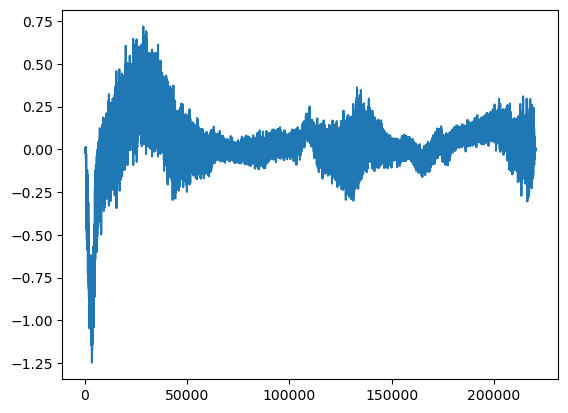

In [11]:
plt.plot(audio.get())

# Combine Audio & Video

In [ ]:
combined_filename = f'combination_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}.mp4'

# Construct the ffmpeg command to combine video and audio
ffmpeg_command = [
    'ffmpeg',
    '-i', video_filename,   # Input video file
    '-i', audio_filename,   # Input audio file
    '-c:v', 'copy',         # Copy the video stream
    '-c:a', 'aac',          # Encode the audio to AAC (necessary for some formats)
    '-shortest',            # Finish encoding when the shortest input stream ends
    combined_filename         # Output file
]

# Execute the command
subprocess.run(ffmpeg_command)